# [ LG에너지솔루션 DX Expert 양성과정 ]

Deep Auto-Encoder를 활용한 time-series anomaly detection
- 이론교육 자료 [ link ](http://dsba.korea.ac.kr/wp-content/uploads/2023/06/8_2%E1%84%8C%E1%85%AE-3%E1%84%8B%E1%85%B5%E1%86%AF-Deep-Auto-Encoder-%E1%84%80%E1%85%B5%E1%86%B7%E1%84%86%E1%85%B5%E1%84%89%E1%85%AE%E1%86%A8.pdf)

# Import modules

In [ ]:
import numpy as np
import pandas as pd
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD

from sklearn.metrics import roc_auc_score
from itertools import groupby, accumulate

import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Functions

In [ ]:
def torch_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)


def train(
    model, dataloader, criterion, optimizer, log_interval: int, device: str) -> list:

    total_loss = []

    model.train()
    for i, (inputs, _) in enumerate(dataloader):

        # convert device
        inputs = inputs.to(device)

        # model outputs
        outputs = model(inputs)

        # loss
        loss = criterion(inputs, outputs).mean()
        total_loss.append(loss.item())

        # calculate gradients
        loss.backward()

        # update model weights
        optimizer.step()
        optimizer.zero_grad()

        # log learning history
        if i % log_interval == 0 or (i+1) == len(dataloader):
            print(f"{'TRAIN':5s} [{i+1:5d}/{len(dataloader):5d}] loss: {np.mean(total_loss):.4f}")

    # average loss
    avg_loss = np.mean(total_loss)

    return avg_loss

def test(
    model, dataloader, criterion, log_interval: int, device: str) -> list:

    # for auroc
    total_loss = []
    total_inputs = []
    total_targets = []
    total_outputs = []

    torch_seed(223)
    model.eval()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            # get inputs and targets
            total_inputs.extend(inputs.numpy())
            total_targets.extend(targets.numpy())

            # convert device
            inputs = inputs.to(device)

            # model outputs
            outputs = model(inputs)
            total_outputs.extend(outputs.cpu().numpy())

            # loss
            loss = criterion(inputs, outputs).max(dim=-1)[0]
            total_loss.extend(loss.cpu().numpy())

            # log learning history
            if i % log_interval == 0 or (i+1) == len(dataloader):
                print(f"{'TSET':5s} [{i+1:5d}/{len(dataloader):5d}] loss: {np.mean(total_loss):.4f}")

    # total inputs, outputs, targets and loss
    total_inputs = np.concatenate(total_inputs, axis=0)
    total_outputs = np.concatenate(total_outputs, axis=0)
    total_targets = np.array(total_targets).reshape(-1)
    total_loss = np.array(total_loss).reshape(-1)

    # auroc
    if sum(total_targets) == 0:
        auroc = 1.
    else:
        auroc = roc_auc_score(total_targets, total_loss)

    # return
    return auroc, total_inputs, total_outputs, total_loss


def fit(
    model, trainloader, testloader, criterion, optimizer,
    epochs: int, log_interval: int, device: str) -> list:

    train_history = []
    test_history_auroc = []

    # fitting model
    for i in range(epochs):
        print(f'\nEpoch: [{i+1}/{epochs}]')
        train_loss = train(
            model        = model,
            dataloader   = trainloader,
            criterion    = criterion,
            optimizer    = optimizer,
            log_interval = log_interval,
            device       = device
        )

        test_auroc, total_inputs, total_outputs, total_loss = test(
            model        = model,
            dataloader   = testloader,
            criterion    = criterion,
            log_interval = log_interval,
            device       = device
        )

        print(f'\nTest AUROC: {test_auroc:.4f}')

        # show results
        plt.figure(figsize=(15,4))
        sns.lineplot(x=range(len(total_inputs)), y=total_inputs[:,0], label='inputs')
        sns.lineplot(x=range(len(total_outputs)), y=total_outputs[:,0], label='reconstruction')
        sns.lineplot(x=range(len(total_loss)), y=total_loss, label='anomaly score')

        # set title
        plt.title("testset anomal score")
        plt.xlabel("time index")
        plt.ylabel("value")
        plt.tight_layout()
        plt.show()

        # stack history
        train_history.append(train_loss)
        test_history_auroc.append(test_auroc)

    return train_history, test_history_auroc


def figure(
    all_train_history: list, all_test_history_auroc: list, all_exp_name: list) -> None:

    fig, ax = plt.subplots(1, 2, figsize=(15,7))

    # train line plot
    for i, (train_h, exp_name) in enumerate(zip(all_train_history, all_exp_name)):
        sns.lineplot(
            x     = range(1, len(train_h)+1),
            y     = train_h,
            label = exp_name,
            ax    = ax[0]
        )

    # test AUROC lineplot
    for i, (test_h, exp_name) in enumerate(zip(all_test_history_auroc, all_exp_name)):
        sns.lineplot(
            x     = range(1, len(test_h)+1),
            y     = test_h,
            label = exp_name,
            ax    = ax[1]
        )


    # set y axis label
    ax[0].set_ylabel('MSE Loss')
    ax[1].set_ylabel('AUROC')

    # set x axis label
    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs')

    # set title
    ax[0].set_title('Train loss history')
    ax[1].set_title('Test AUROC(image-level) history')

    # set y value limit
    max_train = np.max(all_train_history)

    ax[0].set_ylim(0, max_train+0.01)
    ax[1].set_ylim(0, 1)

    # set legend
    ax[0].legend(loc='upper left')
    ax[1].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Configuration for experiments

In [ ]:
class Config:
    # dataset 관련 parameters
    window = 100
    stride = 10

    # make dataset
    sin_sequence = 100
    repeat = 30

    # synthesis anomaly setting
    anomaly_sequence = 10
    anomaly_region = 5

    # training 관련 parameters
    epochs = 20
    batch_size = 8
    test_batch_size = 128
    learning_rate = 0.001
    num_workers = 2
    log_interval = 2000

    # device
    device = 'cuda'

    # seed
    seed = 223

cfg = Config()

## make dataset

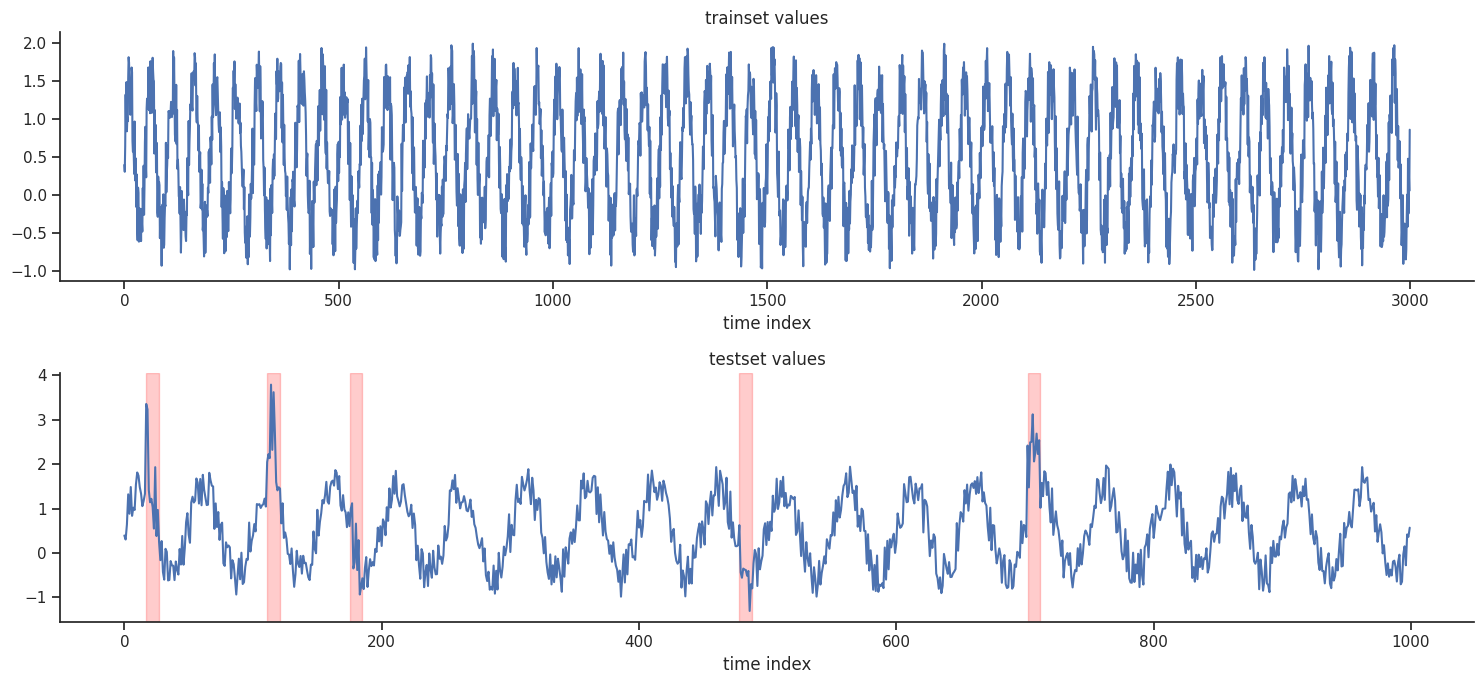

In [ ]:
# trainset
x_train = np.array([np.sin(i*np.pi) for i in np.linspace(start=-2, stop=2, num=cfg.sin_sequence)] * cfg.repeat)
x_train = x_train + np.random.random(cfg.sin_sequence * cfg.repeat)
y_train = np.zeros(len(x_train))

# testset
x_test = x_train[:1000].copy()
y_test = np.zeros(len(x_test))

torch_seed(cfg.seed)
anomaly_idx = np.random.choice(range(len(x_test)), size=cfg.anomaly_region)

for ano_idx in anomaly_idx:
    x_test[ano_idx:ano_idx+cfg.anomaly_sequence] = x_test[ano_idx:ano_idx+cfg.anomaly_sequence] * 2
    y_test[ano_idx:ano_idx+cfg.anomaly_sequence] = 1

# plot
fig, ax = plt.subplots(2,1,figsize=(15,7))
sns.lineplot(x=range(len(x_train)), y=x_train, ax=ax[0])
ax[0].set_title('trainset values')
ax[0].set_xlabel('time index')

sns.lineplot(x=range(len(x_test)), y=x_test, ax=ax[1])
for ano_idx in anomaly_idx:
    ax[1].axvspan(ano_idx, ano_idx+cfg.anomaly_sequence, color='red', alpha=0.2)
ax[1].set_title('testset values')
ax[1].set_xlabel('time index')
plt.tight_layout()
plt.show()


In [ ]:
class TSADDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, window: int, stride: int):
        self.X = X
        self.y = y

        self.window = window
        self.stride = stride

        # start index
        self.start_index = list(range(0, len(self.X) - cfg.window + 1, self.stride))


    def __getitem__(self, idx):
        s_idx = self.start_index[idx]
        input = self.X[s_idx:s_idx+self.window]
        target = self.y[s_idx:s_idx+self.window]

        input = torch.FloatTensor(input).unsqueeze(-1)

        return input, target

    def __len__(self):
        return len(self.start_index)

In [ ]:
trainset = TSADDataset(
    X      = x_train,
    y      = y_train,
    window = cfg.window,
    stride = cfg.stride
)

testset = TSADDataset(
    X      = x_test,
    y      = y_test,
    window = cfg.window,
    stride = cfg.window
)

trainloader = DataLoader(trainset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
testloader = DataLoader(testset, batch_size=cfg.test_batch_size, shuffle=False, num_workers=cfg.num_workers)

# RNN Auto-Encoder

In [ ]:
class RNNAutoEncoder(nn.Module):
    def __init__(self, input_dim: int, hidden_size: int, num_layers: int):
        super().__init__()

        # encoder
        self.enc = nn.RNN(
            input_size  = input_dim,
            hidden_size = hidden_size,
            num_layers  = num_layers,
            batch_first = True
        )

        # decoder
        self.dec = nn.RNN(
            input_size  = input_dim,
            hidden_size = hidden_size,
            num_layers  = num_layers,
            batch_first = True
        )

        self.output = nn.Linear(in_features=hidden_size, out_features=input_dim)

    def encoder(self, x):
        out, hidden = self.enc(x)

        return out, hidden

    def decoder(self, x, hidden):
        out, hidden = self.dec(x, hidden)
        out = self.output(out)

        return out, hidden

    def forward(self, x):
        batch_size, seq_len, dims = x.size()

        # encoder
        out, hidden = self.encoder(x)

        # decoder
        x_rec = torch.zeros_like(x).to(x.device)
        x_dec = torch.zeros((batch_size, 1, dims), dtype=torch.float).to(x.device)
        for i in range(seq_len):
            out_dec_i, hidden = self.decoder(x_dec, hidden)
            x_rec[:,i,:] = out_dec_i[:,0,:]
            x_dec = out_dec_i

        return x_rec

In [ ]:
torch_seed(cfg.seed)
rae = RNNAutoEncoder(input_dim=1, hidden_size=32, num_layers=2)
rae.to(cfg.device)
print('load RNN Auto-Encoder')
print('The number of model parameters: ',sum([p.numel() for p in rae.parameters()]))

criterion = nn.MSELoss(reduction='none')
optimizer = Adam(rae.parameters(), lr=cfg.learning_rate)

load RNN Auto-Encoder
The number of model parameters:  6497



Epoch: [1/20]
TRAIN [    1/   37] loss: 0.7649
TRAIN [   37/   37] loss: 0.5952
TSET  [    1/    1] loss: 0.6520

Test AUROC: 0.7406


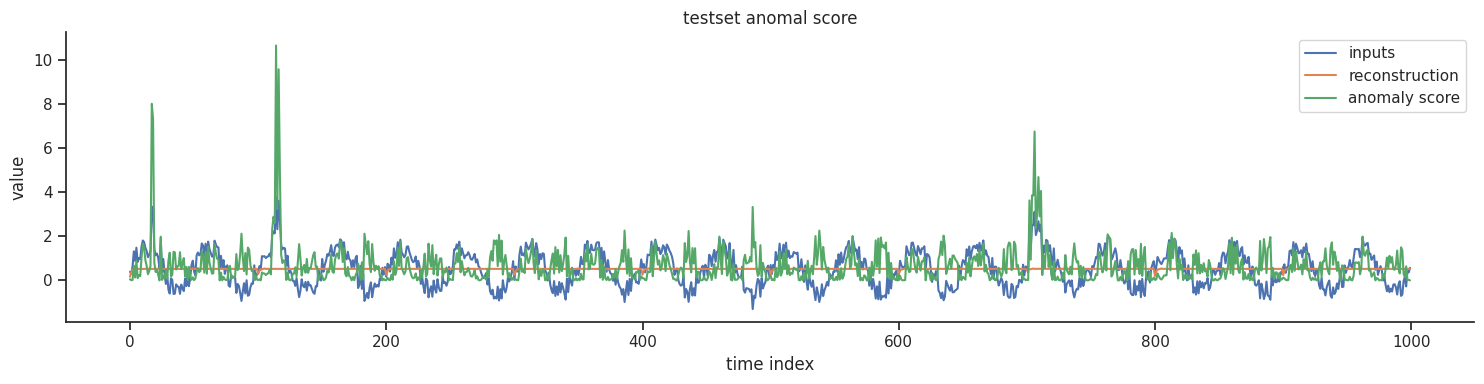


Epoch: [2/20]
TRAIN [    1/   37] loss: 0.5391
TRAIN [   37/   37] loss: 0.5652
TSET  [    1/    1] loss: 0.6528

Test AUROC: 0.7409


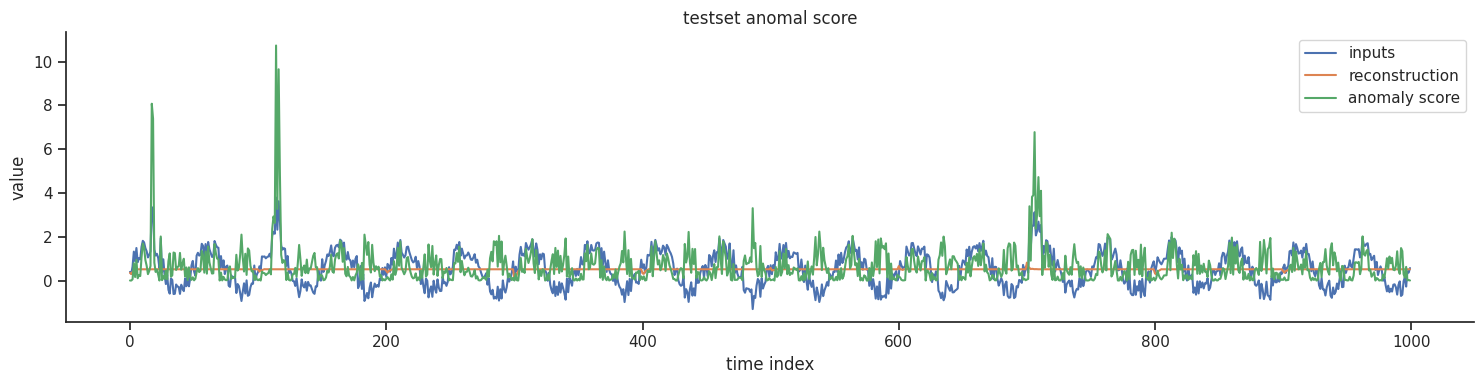


Epoch: [3/20]
TRAIN [    1/   37] loss: 0.5316
TRAIN [   37/   37] loss: 0.5533
TSET  [    1/    1] loss: 0.6342

Test AUROC: 0.7355


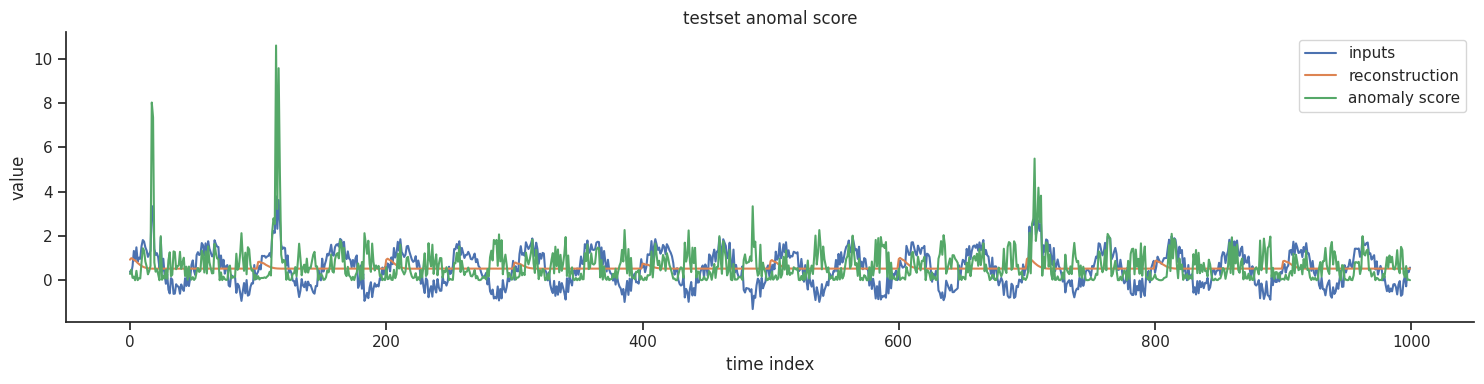


Epoch: [4/20]
TRAIN [    1/   37] loss: 0.5188
TRAIN [   37/   37] loss: 0.5380
TSET  [    1/    1] loss: 0.5998

Test AUROC: 0.7513


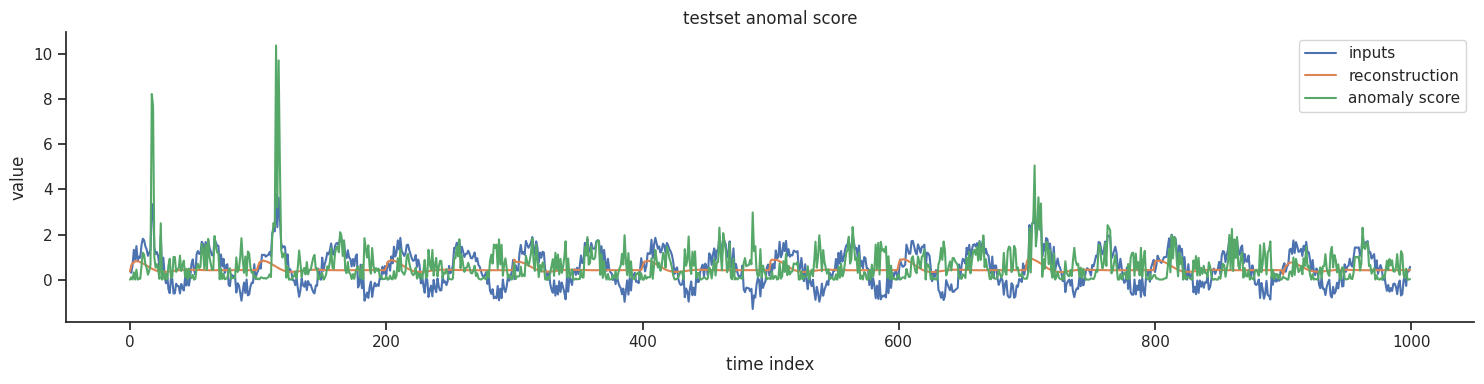


Epoch: [5/20]
TRAIN [    1/   37] loss: 0.5019
TRAIN [   37/   37] loss: 0.4298
TSET  [    1/    1] loss: 0.2697

Test AUROC: 0.7229


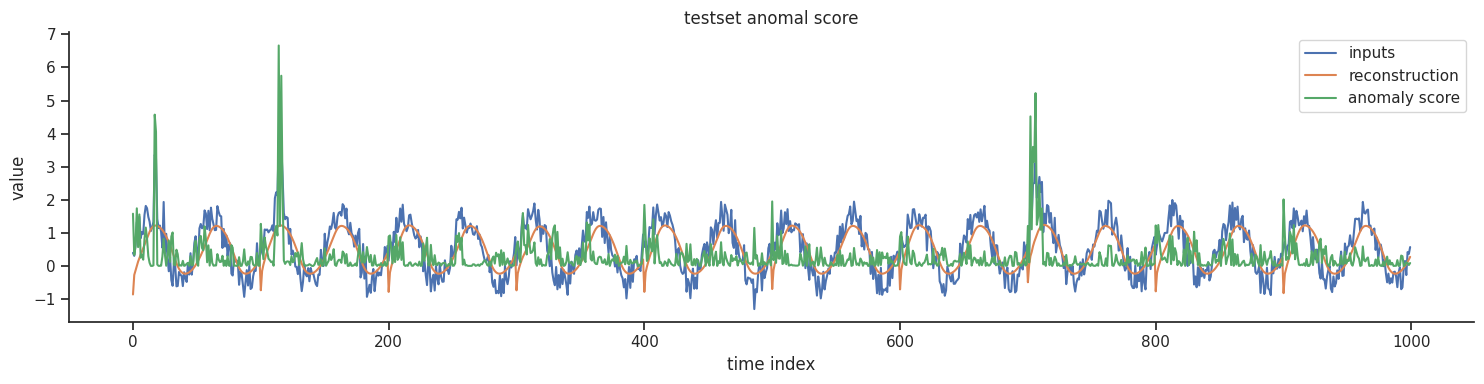


Epoch: [6/20]
TRAIN [    1/   37] loss: 0.3471
TRAIN [   37/   37] loss: 0.2453
TSET  [    1/    1] loss: 0.2022

Test AUROC: 0.7468


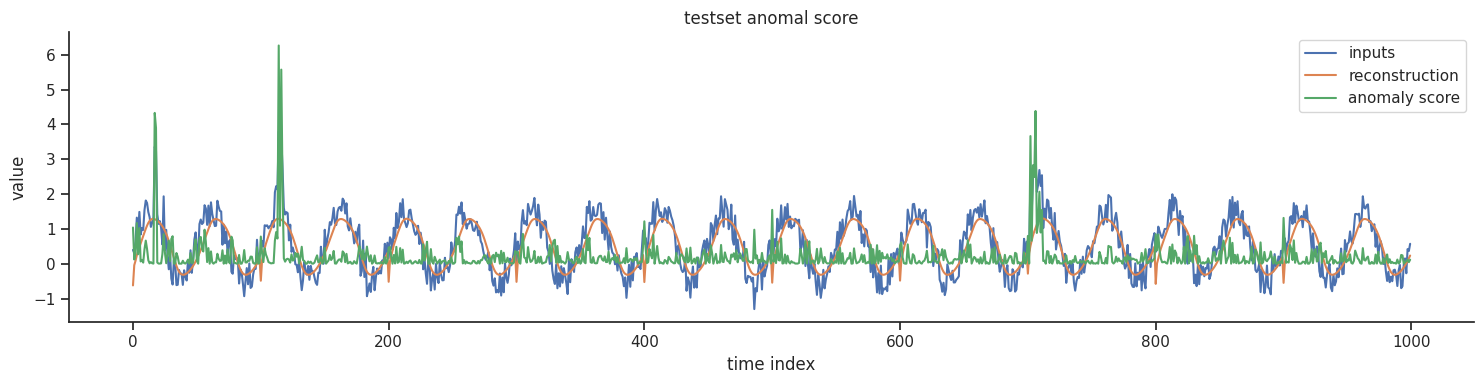


Epoch: [7/20]
TRAIN [    1/   37] loss: 0.2033
TRAIN [   37/   37] loss: 0.1320
TSET  [    1/    1] loss: 0.1306

Test AUROC: 0.7134


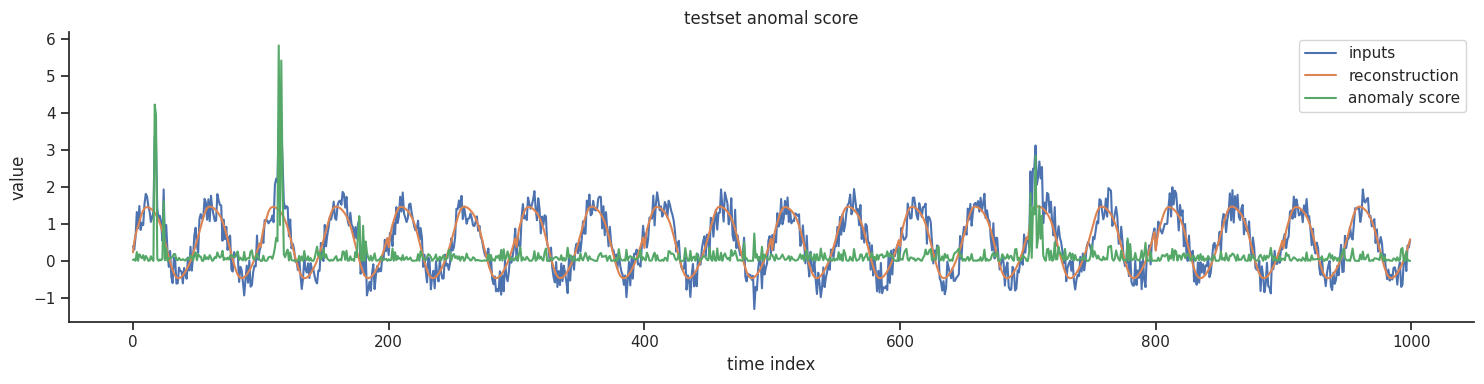


Epoch: [8/20]
TRAIN [    1/   37] loss: 0.1158
TRAIN [   37/   37] loss: 0.1008
TSET  [    1/    1] loss: 0.1395

Test AUROC: 0.7139


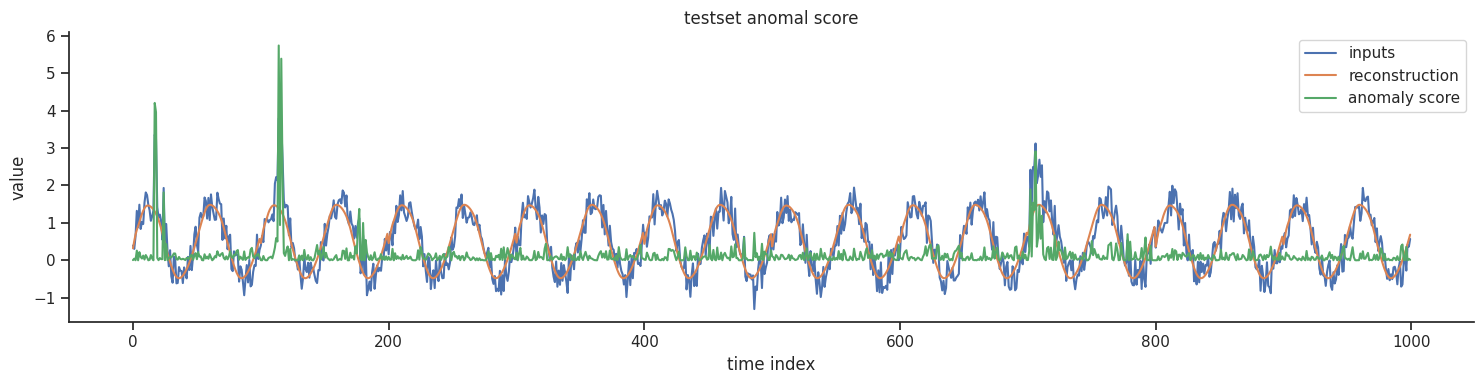


Epoch: [9/20]
TRAIN [    1/   37] loss: 0.1055
TRAIN [   37/   37] loss: 0.0914
TSET  [    1/    1] loss: 0.1309

Test AUROC: 0.7171


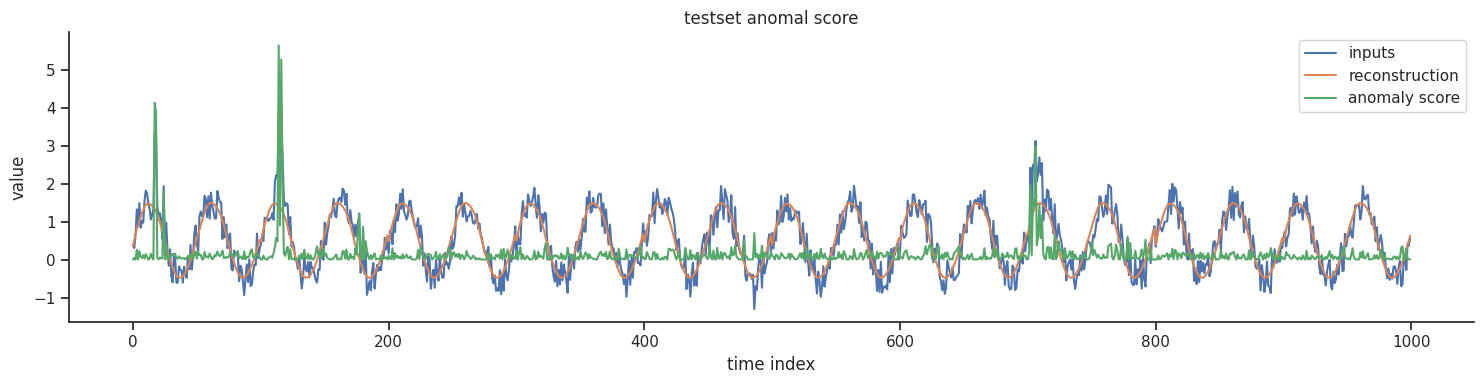


Epoch: [10/20]
TRAIN [    1/   37] loss: 0.0961
TRAIN [   37/   37] loss: 0.0905
TSET  [    1/    1] loss: 0.1250

Test AUROC: 0.7283


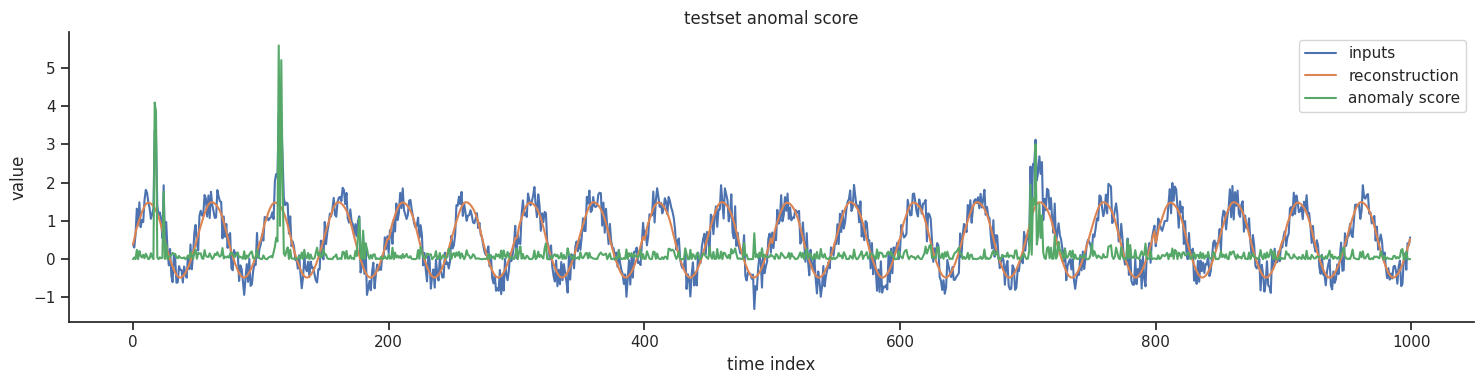


Epoch: [11/20]
TRAIN [    1/   37] loss: 0.0890
TRAIN [   37/   37] loss: 0.0905
TSET  [    1/    1] loss: 0.1237

Test AUROC: 0.7323


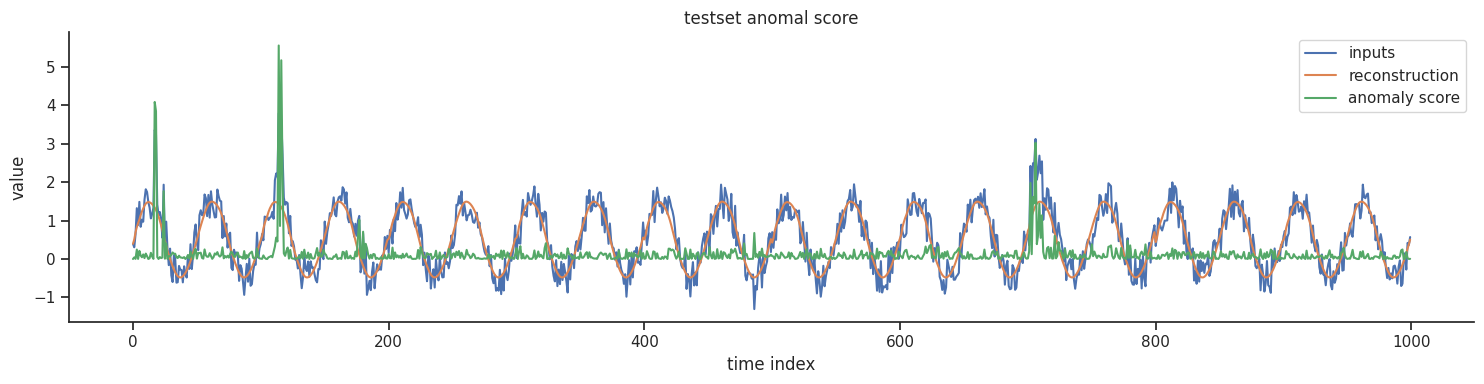


Epoch: [12/20]
TRAIN [    1/   37] loss: 0.0872
TRAIN [   37/   37] loss: 0.0899
TSET  [    1/    1] loss: 0.1232

Test AUROC: 0.7330


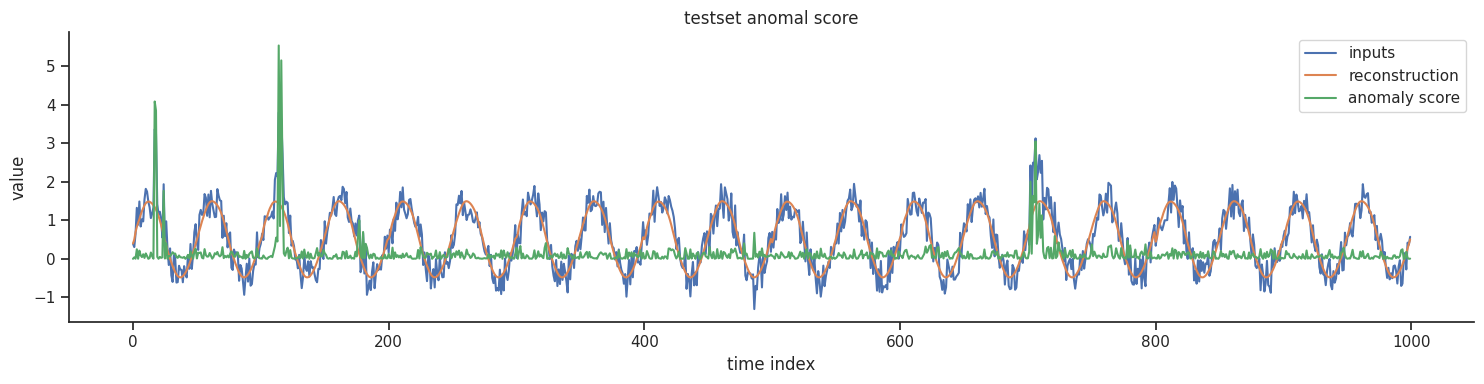


Epoch: [13/20]
TRAIN [    1/   37] loss: 0.0866
TRAIN [   37/   37] loss: 0.0895
TSET  [    1/    1] loss: 0.1225

Test AUROC: 0.7358


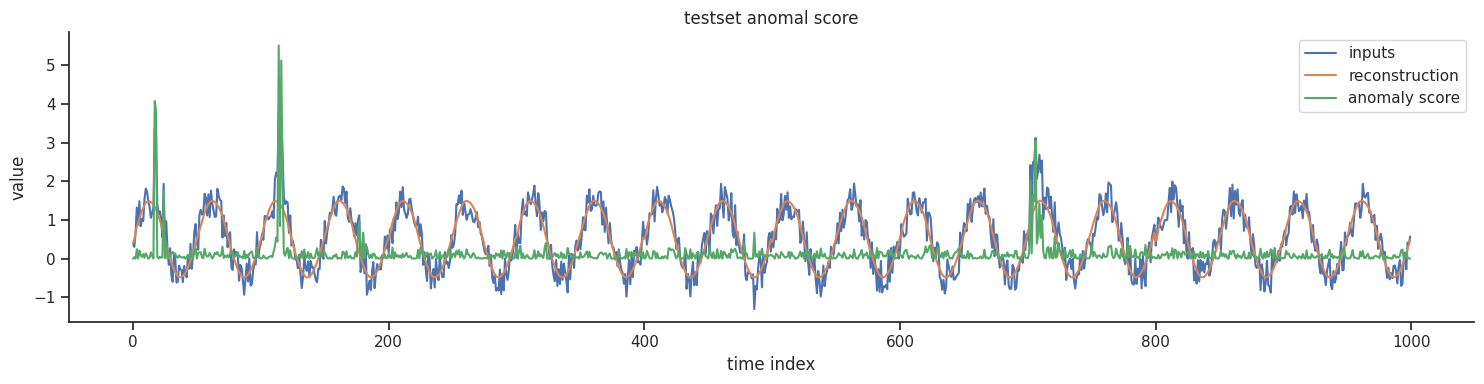


Epoch: [14/20]
TRAIN [    1/   37] loss: 0.0859
TRAIN [   37/   37] loss: 0.0893
TSET  [    1/    1] loss: 0.1220

Test AUROC: 0.7372


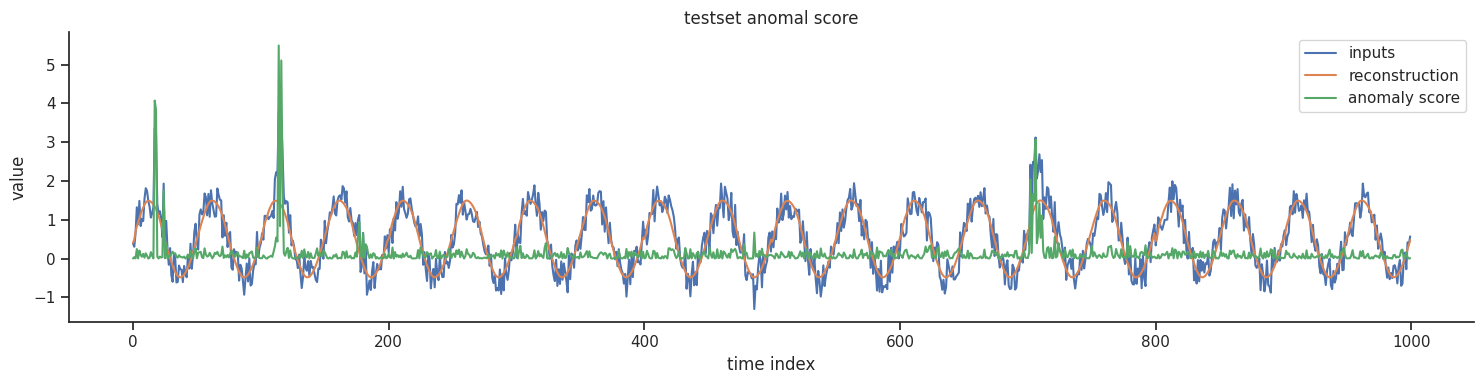


Epoch: [15/20]
TRAIN [    1/   37] loss: 0.0854
TRAIN [   37/   37] loss: 0.0889
TSET  [    1/    1] loss: 0.1216

Test AUROC: 0.7392


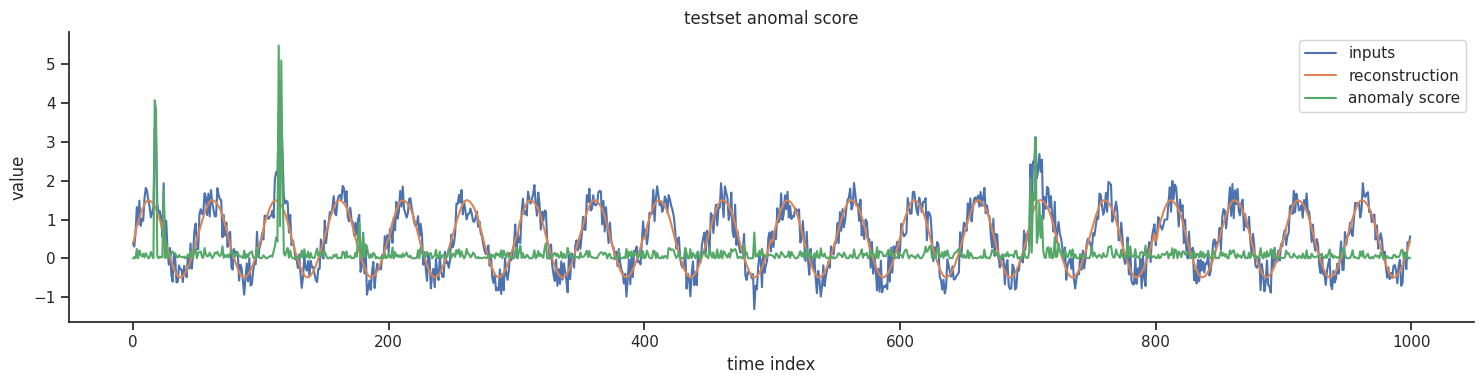


Epoch: [16/20]
TRAIN [    1/   37] loss: 0.0850
TRAIN [   37/   37] loss: 0.0886
TSET  [    1/    1] loss: 0.1213

Test AUROC: 0.7412


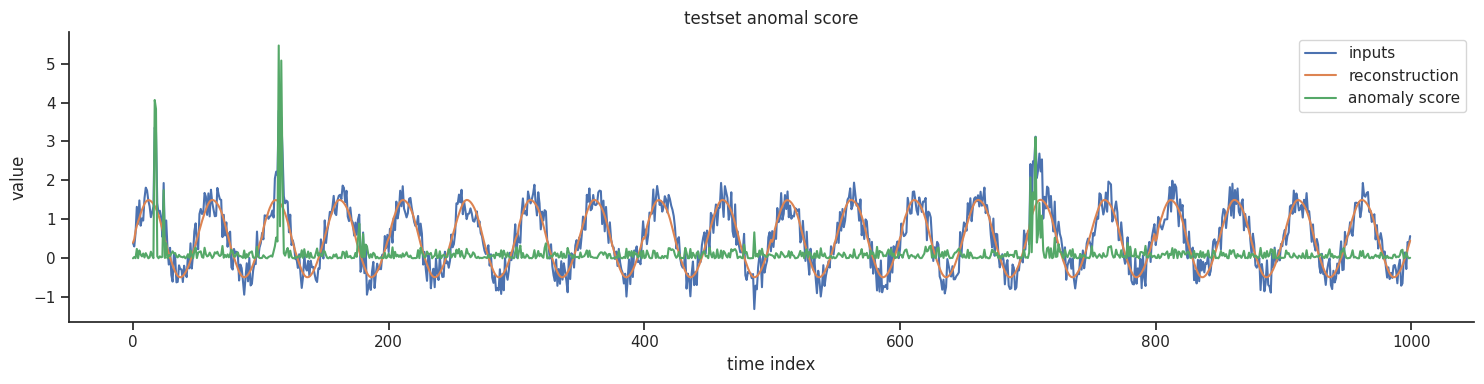


Epoch: [17/20]
TRAIN [    1/   37] loss: 0.0847
TRAIN [   37/   37] loss: 0.0883
TSET  [    1/    1] loss: 0.1210

Test AUROC: 0.7426


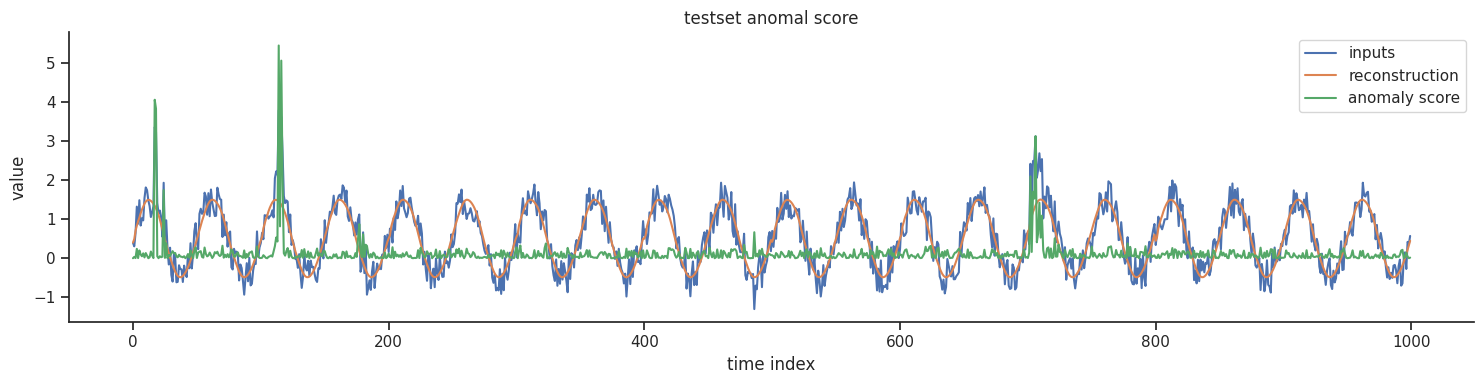


Epoch: [18/20]
TRAIN [    1/   37] loss: 0.0844
TRAIN [   37/   37] loss: 0.0881
TSET  [    1/    1] loss: 0.1208

Test AUROC: 0.7440


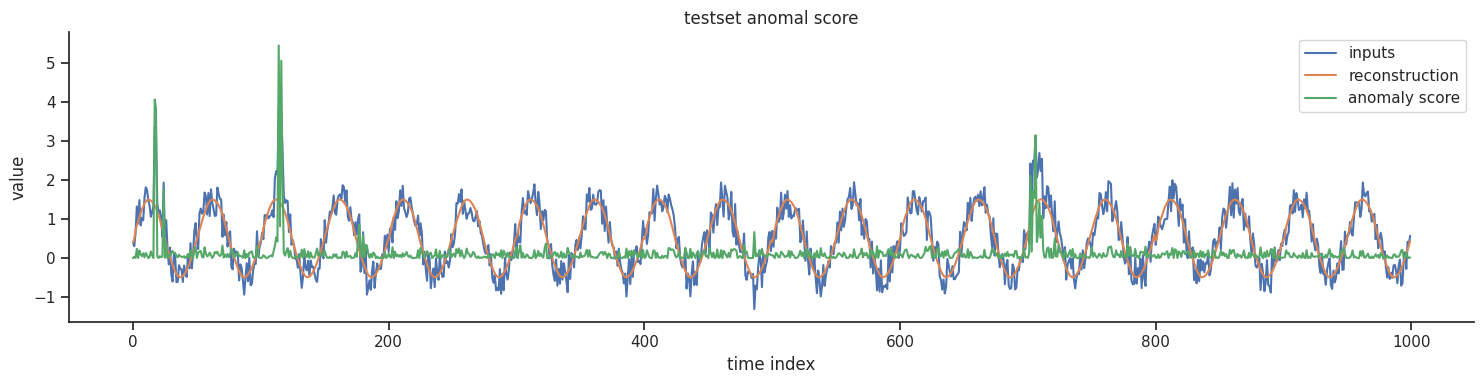


Epoch: [19/20]
TRAIN [    1/   37] loss: 0.0842
TRAIN [   37/   37] loss: 0.0878
TSET  [    1/    1] loss: 0.1207

Test AUROC: 0.7449


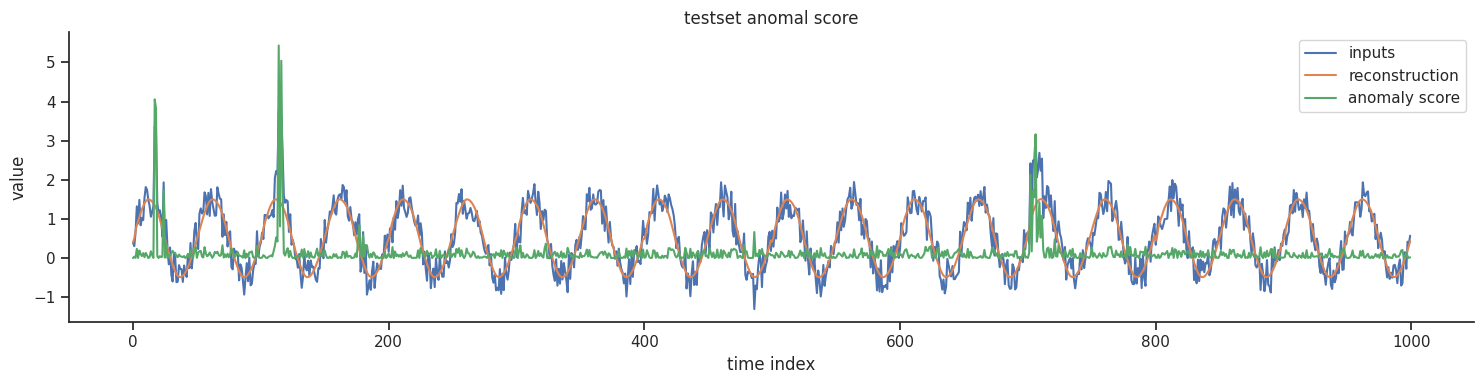


Epoch: [20/20]
TRAIN [    1/   37] loss: 0.0840
TRAIN [   37/   37] loss: 0.0876
TSET  [    1/    1] loss: 0.1206

Test AUROC: 0.7454


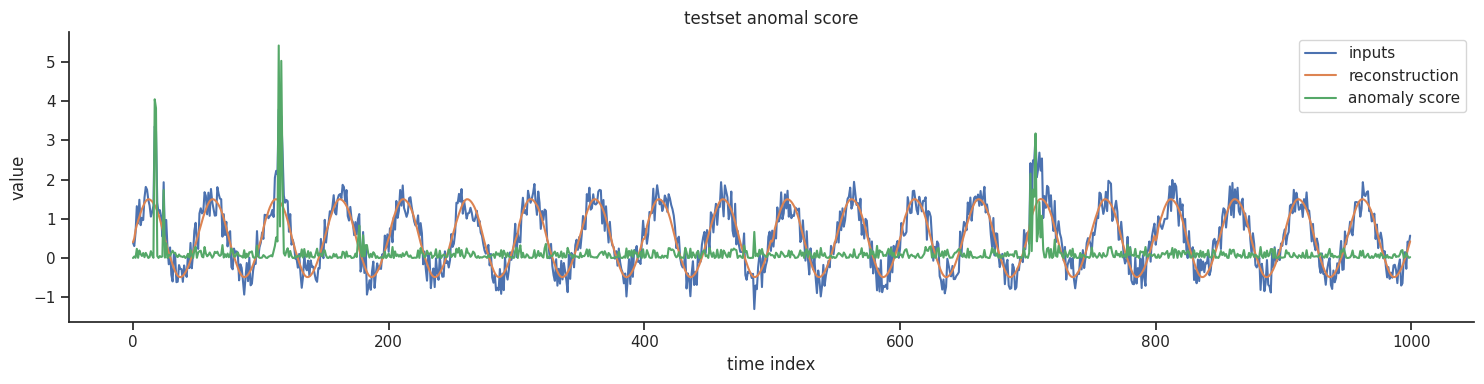

In [ ]:
torch_seed(cfg.seed)
train_history_rae, test_history_auroc_rae = fit(
    model        = rae,
    trainloader  = trainloader,
    testloader   = testloader,
    criterion    = criterion,
    optimizer    = optimizer,
    epochs       = cfg.epochs,
    log_interval = cfg.log_interval,
    device       = cfg.device
)

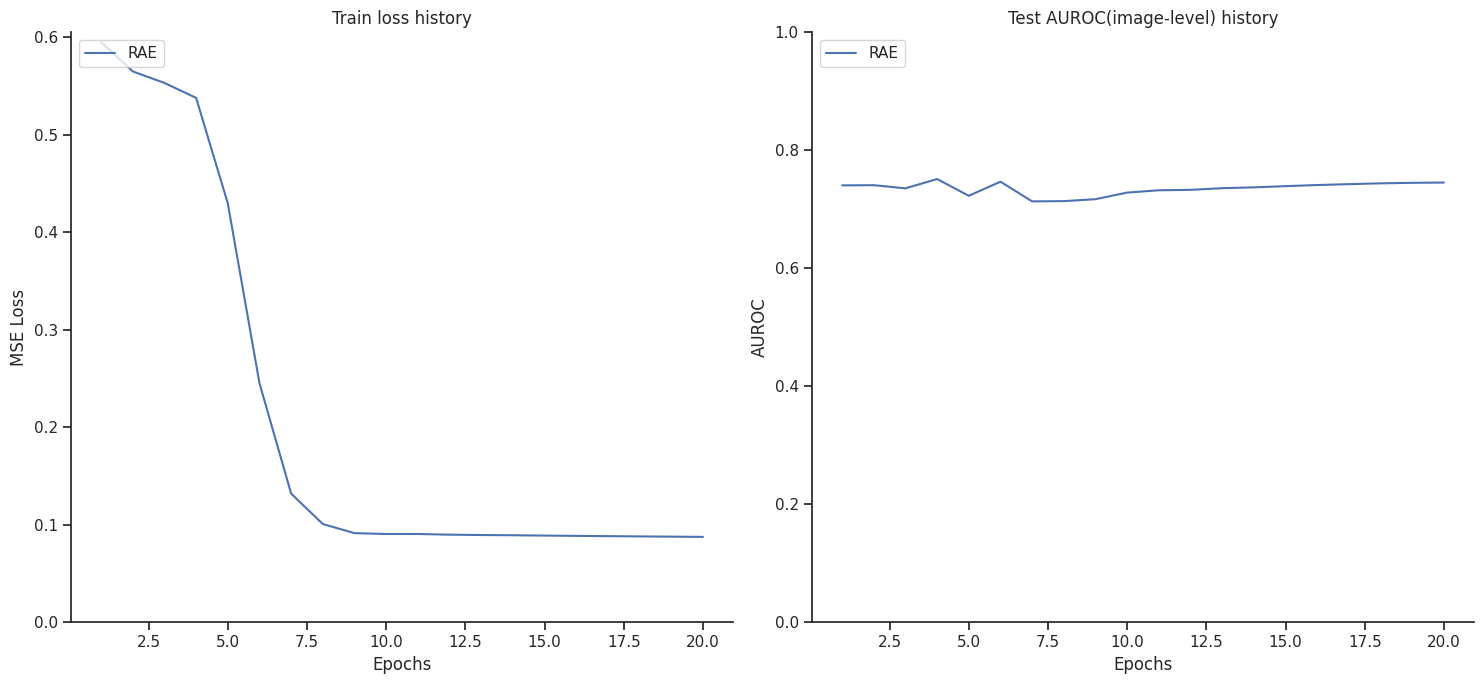

In [ ]:
all_train_history = [train_history_rae]
all_test_history_auroc = [test_history_auroc_rae]
all_exp_name = ['RAE']

figure(
    all_train_history      = all_train_history,
    all_test_history_auroc = all_test_history_auroc,
    all_exp_name           = all_exp_name
)

# Visualization

In [ ]:
trainset = TSADDataset(
    X      = x_train,
    y      = y_train,
    window = cfg.window,
    stride = cfg.window
)

trainloader = DataLoader(trainset, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

TSET  [    1/    4] loss: 0.0853
TSET  [    4/    4] loss: 0.0830


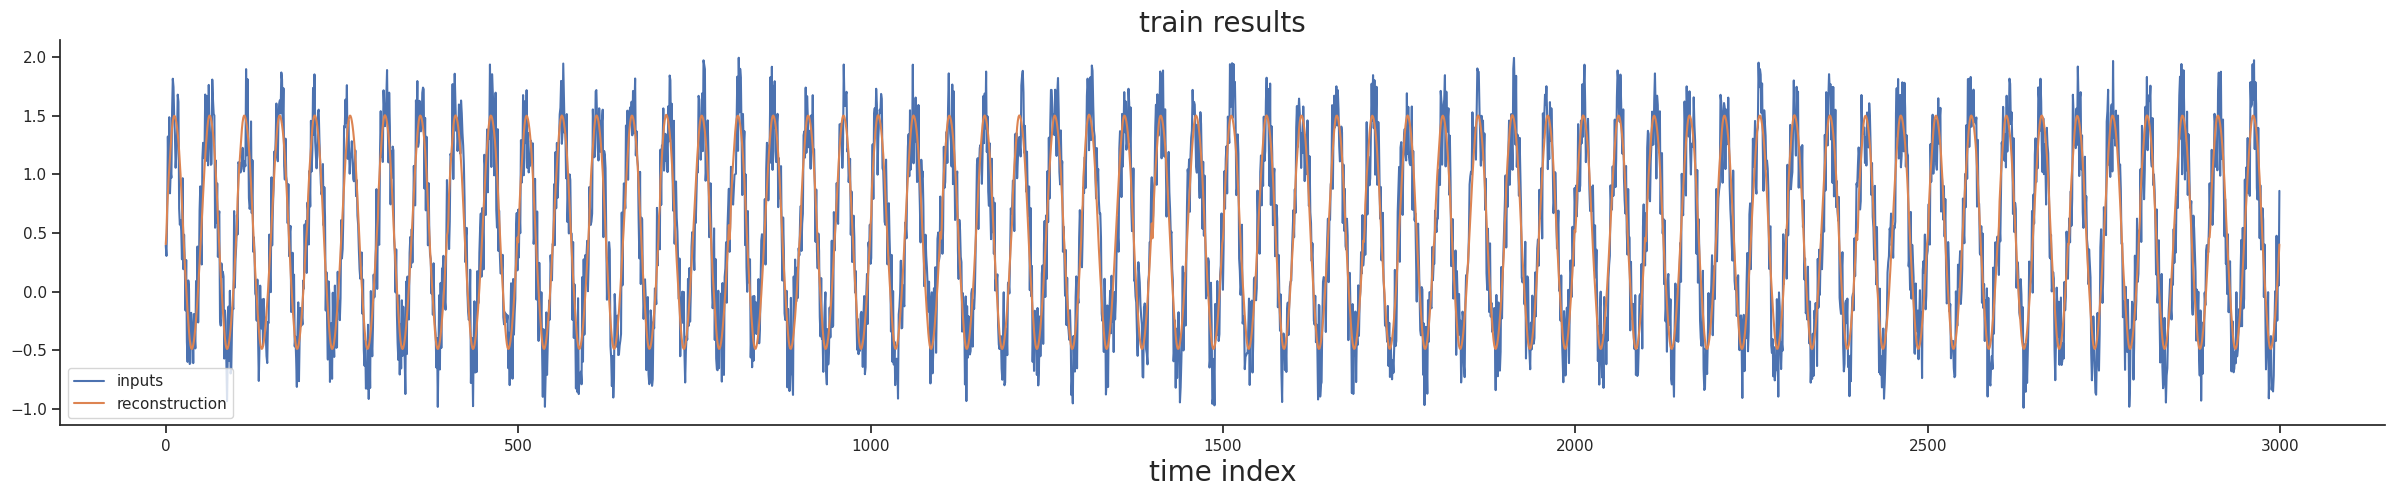

In [ ]:
_, total_inputs, total_outputs, total_loss = test(
    model        = rae,
    dataloader   = trainloader,
    criterion    = criterion,
    log_interval = cfg.log_interval,
    device       = cfg.device
)

# show results
fig, ax = plt.subplots(figsize=(30,5))

sns.lineplot(x=range(len(total_inputs)), y=total_inputs[:,0], label='inputs', ax=ax)
sns.lineplot(x=range(len(total_outputs)), y=total_outputs[:,0], label='reconstruction', ax=ax)
ax.set_title('train results', size=20)
ax.set_xlabel('time index', size=20)
plt.show()

In [ ]:
def anomaly_region(anomaly_score, threshold):
    indices = list(accumulate(len(list(g)) for i,g in groupby((anomaly_score > threshold))))
    starts = indices[:len(indices)//2*2:2]
    stops = [i-1 for i in indices[1::2]]

    return starts, stops

TSET  [    1/    1] loss: 0.1206


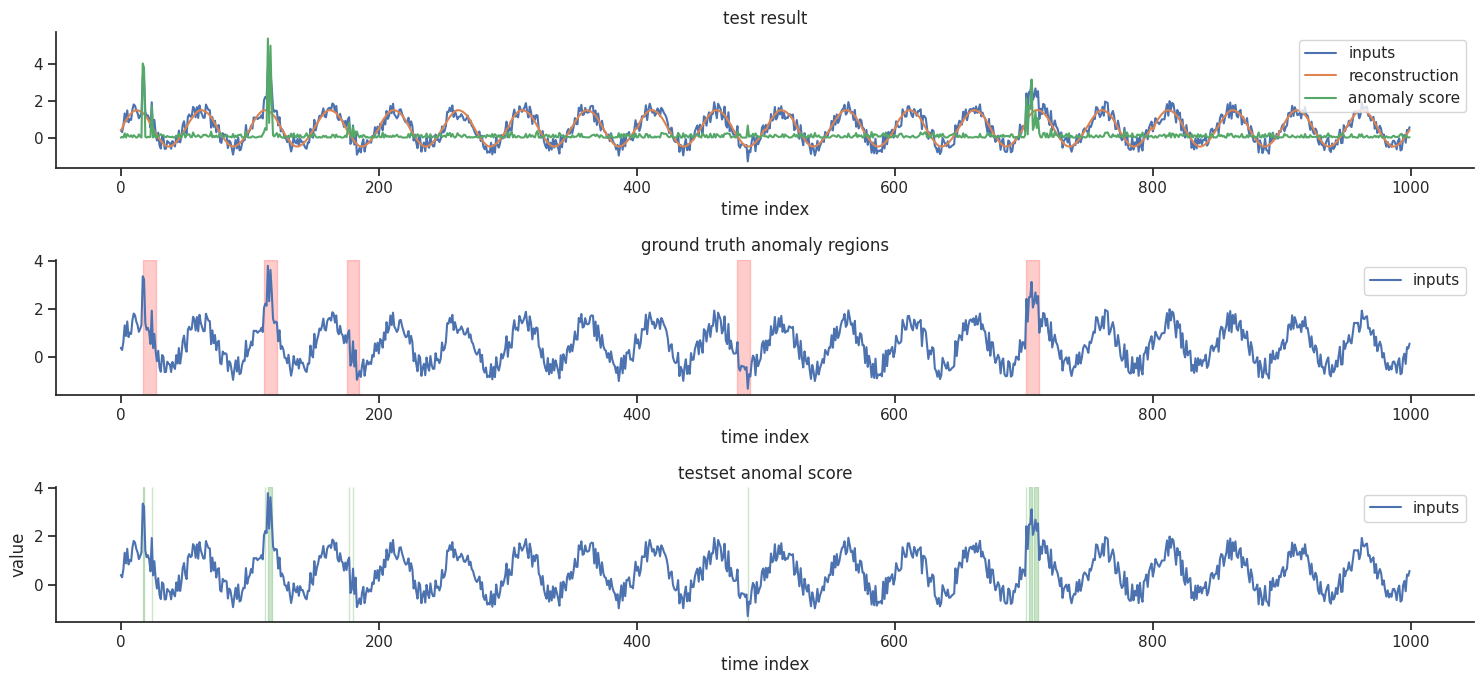

In [ ]:
_, total_inputs, total_outputs, total_loss = test(
    model        = rae,
    dataloader   = testloader,
    criterion    = criterion,
    log_interval = cfg.log_interval,
    device       = cfg.device
)

# show results
fig, ax = plt.subplots(3,1, figsize=(15,7))

sns.lineplot(x=range(len(total_inputs)), y=total_inputs[:,0], label='inputs', ax=ax[0])
sns.lineplot(x=range(len(total_outputs)), y=total_outputs[:,0], label='reconstruction', ax=ax[0])
sns.lineplot(x=range(len(total_loss)), y=total_loss, label='anomaly score', ax=ax[0])
ax[0].set_title('test result')
ax[0].set_xlabel('time index')

# ground truth
sns.lineplot(x=range(len(total_inputs)), y=total_inputs[:,0], label='inputs', ax=ax[1])
for ano_idx in anomaly_idx:
    ax[1].axvspan(ano_idx, ano_idx+cfg.anomaly_sequence, color='red', alpha=0.2)
ax[1].set_title('ground truth anomaly regions')
ax[1].set_xlabel('time index')


# anomaly regions
sns.lineplot(x=range(len(total_inputs)), y=total_inputs[:,0], label='inputs', ax=ax[2])
starts, stops = anomaly_region(total_loss, threshold=0.5)
for start_idx, end_idx in zip(starts, stops):
    ax[2].axvspan(start_idx, end_idx, color='green', alpha=0.2)
ax[2].set_title('prediction anomaly regions')
ax[2].set_xlabel('time index')


# set title
plt.title("testset anomal score")
plt.xlabel("time index")
plt.ylabel("value")
plt.tight_layout()
plt.show()